# Operators

In [1]:
import numpy as np

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import BasicAer
from qiskit.compiler import transpile
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.quantum_info import process_fidelity

from qiskit.extensions import RXGate, XGate, CXGate

## Operator Class

The `Operator` class is used in Qiskit to represent matrix operators acting on a quantum system. It has several methods to build composite operators using tensor products of smaller operators, and to compose operators.

### Creating Operators

The easiest way to create an operator object is to initialize it with a matrix given as a list or a Numpy array. For example, to create a two-qubit Pauli-XX operator:

In [2]:
XX = Operator([[0, 0, 0, 1], [0, 0, 1, 0], [0, 1, 0, 0], [1, 0, 0, 0]])
XX

Operator([[0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
          [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
          [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
          [1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))

### Operator Properties

The operator object stores the underlying matrix, and the input and output dimension of subsystems. 

* `data`: To access the underlying Numpy array, we may use the `Operator.data` property.
* `dims`: To return the total input and output dimension of the operator, we may use the `Operator.dim` property. *Note: the output is returned as a tuple* `(input_dim, output_dim)`, *which is the reverse of the shape of the underlying matrix.*

In [3]:
XX.data

array([[0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]])

In [4]:
input_dim, output_dim = XX.dim
input_dim, output_dim

(4, 4)

### Input and Output Dimensions

The operator class also keeps track of subsystem dimensions, which can be used for composing operators together. These can be accessed using the `input_dims` and `output_dims` functions.

For $2^N$ by $2^M$ operators, the input and output dimension will be automatically assumed to be M-qubit and N-qubit:

In [5]:
op = Operator(np.random.rand(2 ** 1, 2 ** 2))
print('Input dimensions:', op.input_dims())
print('Output dimensions:', op.output_dims())

Input dimensions: (2, 2)
Output dimensions: (2,)


If the input matrix is not divisible into qubit subsystems, then it will be stored as a single-qubit operator. For example, if we have a $6\times6$ matrix:

In [6]:
op = Operator(np.random.rand(6, 6))
print('Input dimensions:', op.input_dims())
print('Output dimensions:', op.output_dims())

Input dimensions: (6,)
Output dimensions: (6,)


The input and output dimension can also be manually specified when initializing a new operator:

In [7]:
# Force input dimension to be (4,) rather than (2, 2)
op = Operator(np.random.rand(2 ** 1, 2 ** 2), input_dims=[4])
print('Input dimensions:', op.input_dims())
print('Output dimensions:', op.output_dims())

Input dimensions: (4,)
Output dimensions: (2,)


In [8]:
# Specify system is a qubit and qutrit
op = Operator(np.random.rand(6, 6),
              input_dims=[2, 3], output_dims=[2, 3])
print('Input dimensions:', op.input_dims())
print('Output dimensions:', op.output_dims())

Input dimensions: (2, 3)
Output dimensions: (2, 3)


We can also extract just the input or output dimensions of a subset of subsystems using the `input_dims` and `output_dims` functions:

In [9]:
print('Dimension of input system 0:', op.input_dims([0]))
print('Dimension of input system 1:', op.input_dims([1]))

Dimension of input system 0: (2,)
Dimension of input system 1: (3,)


## Converting classes to Operators

Several other classes in Qiskit can be directly converted to an `Operator` object using the operator initialization method. For example:

* `Pauli` objects
* `Gate` and `Instruction` objects
* `QuantumCircuit` objects

Note that the last point means we can use the `Operator` class as a unitary simulator to compute the final unitary matrix for a quantum circuit, without having to call a simulator backend. If the circuit contains any unsupported operations, an exception will be raised. Unsupported operations are: measure, reset, conditional operations, or a gate that does not have a matrix definition or decomposition in terms of gate with matrix definitions.

In [10]:
# Create an Operator from a Pauli object

pauliXX = Pauli('XX')
Operator(pauliXX)

Operator([[0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
          [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
          [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
          [1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))

In [11]:
# Create an Operator for a Gate object
Operator(CXGate())

Operator([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
          [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
          [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))

In [12]:
# Create an operator from a parameterized Gate object
Operator(RXGate(np.pi / 2))

Operator([[0.70710678+0.j        , 0.        -0.70710678j],
          [0.        -0.70710678j, 0.70710678+0.j        ]],
         input_dims=(2,), output_dims=(2,))

In [13]:
# Create an operator from a QuantumCircuit object
circ = QuantumCircuit(10)
circ.h(0)
for j in range(1, 10):
    circ.cx(j-1, j)

# Convert circuit to an operator by implicit unitary simulation
Operator(circ)

Operator([[ 0.70710678+0.j,  0.70710678+0.j,  0.        +0.j, ...,
            0.        +0.j,  0.        +0.j,  0.        +0.j],
          [ 0.        +0.j,  0.        +0.j,  0.70710678+0.j, ...,
            0.        +0.j,  0.        +0.j,  0.        +0.j],
          [ 0.        +0.j,  0.        +0.j,  0.        +0.j, ...,
            0.        +0.j,  0.        +0.j,  0.        +0.j],
          ...,
          [ 0.        +0.j,  0.        +0.j,  0.        +0.j, ...,
            0.        +0.j,  0.        +0.j,  0.        +0.j],
          [ 0.        +0.j,  0.        +0.j,  0.70710678+0.j, ...,
            0.        +0.j,  0.        +0.j,  0.        +0.j],
          [ 0.70710678+0.j, -0.70710678+0.j,  0.        +0.j, ...,
            0.        +0.j,  0.        +0.j,  0.        +0.j]],
         input_dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2), output_dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2))

## Using Operators in circuits

Unitary `Operators` can be directly inserted into a `QuantumCircuit` using the `QuantumCircuit.append` method. This converts the `Operator` into a `UnitaryGate` object, which is added to the circuit.

If the operator is not unitary, an exception will be raised. This can be checked using the `Operator.is_unitary()` function, which will return `True` if the operator is unitary and `False` otherwise.

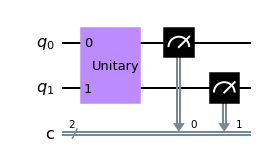

In [14]:
# Create an operator
XX = Operator(Pauli('XX'))

# Add to a circuit
circ = QuantumCircuit(2, 2)
circ.append(XX, [0, 1])
circ.measure([0,1], [0,1])
circ.draw('mpl')

Note that in the above example we initialize the operator from a `Pauli` object. However, the `Pauli` object may also be directly inserted into the circuit itself and will be converted into a sequence of single-qubit Pauli gates:

In [15]:
backend = BasicAer.get_backend('qasm_simulator')
circ = transpile(circ, backend, basis_gates=['u1','u2','u3','cx'])
job = backend.run(circ)
job.result().get_counts(0)

{'11': 1024}

In [16]:
# Add to a circuit
circ2 = QuantumCircuit(2, 2)
circ2.append(Pauli('XX'), [0, 1])
circ2.measure([0,1], [0,1])
circ2.draw()

┌────────────┐┌─┐   
q_0: ┤0           ├┤M├───
     │  Pauli(XX) │└╥┘┌─┐
q_1: ┤1           ├─╫─┤M├
     └────────────┘ ║ └╥┘
c: 2/═══════════════╩══╩═
                    0  1

## Combining Operators

Operators may be combined using several methods. 

### Tensor Product

Two operators $A$ and $B$ may be combined into a tensor product operator $A\otimes B$ using the `Operator.tensor` function. Note that if both $A$ and $B$ are single-qubit operators, then `A.tensor(B)` = $A\otimes B$ will have the subsystems indexed as matrix $B$  on subsystem 0, and matrix $A$ on subsystem 1.

In [17]:
A = Operator(Pauli('X'))
B = Operator(Pauli('Z'))
A.tensor(B)

Operator([[ 0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j],
          [ 0.+0.j, -0.+0.j,  0.+0.j, -1.+0.j],
          [ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
          [ 0.+0.j, -1.+0.j,  0.+0.j, -0.+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))

### Tensor Expansion

A closely related operation is `Operator.expand`, which acts like a tensor product but in the reverse order. Hence, for two operators $A$ and $B$ we have `A.expand(B)` = $B\otimes A$ where the subsystems indexed as matrix $A$ on subsystem 0, and matrix $B$ on subsystem 1.

In [18]:
A = Operator(Pauli('X'))
B = Operator(Pauli('Z'))
A.expand(B)

Operator([[ 0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j],
          [ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
          [ 0.+0.j,  0.+0.j, -0.+0.j, -1.+0.j],
          [ 0.+0.j,  0.+0.j, -1.+0.j, -0.+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))

### Composition

We can also compose two operators $A$ and $B$ to implement matrix multiplication using the `Operator.compose` method. We have that `A.compose(B)` returns the operator with matrix $B.A$:

In [19]:
A = Operator(Pauli('X'))
B = Operator(Pauli('Z'))
A.compose(B)

Operator([[ 0.+0.j,  1.+0.j],
          [-1.+0.j,  0.+0.j]],
         input_dims=(2,), output_dims=(2,))

We can also compose in the reverse order by applying $B$ in front of $A$ using the `front` kwarg of `compose`:  `A.compose(B, front=True)` = $A.B$:

In [20]:
A = Operator(Pauli('X'))
B = Operator(Pauli('Z'))
A.compose(B, front=True)

Operator([[ 0.+0.j, -1.+0.j],
          [ 1.+0.j,  0.+0.j]],
         input_dims=(2,), output_dims=(2,))

### Subsystem Composition

Note that the previous compose requires that the total output dimension of the first operator $A$ is equal to total input dimension of the composed operator $B$ (and similarly, the output dimension of $B$ must be equal to the input dimension of $A$ when composing with `front=True`).

We can also compose a smaller operator with a selection of subsystems on a larger operator using the `qargs` kwarg of `compose`, either with or without `front=True`. In this case, the relevant input and output dimensions of the subsystems being composed must match. *Note that the smaller operator must always be the argument of* `compose` *method.*

For example, to compose a two-qubit gate with a three-qubit Operator:

In [21]:
# Compose XZ with an 3-qubit identity operator
op = Operator(np.eye(2 ** 3))
XZ = Operator(Pauli('XZ'))
op.compose(XZ, qargs=[0, 2])

Operator([[ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j],
          [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j, -1.+0.j,  0.+0.j,
            0.+0.j],
          [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j,
            0.+0.j],
          [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
           -1.+0.j],
          [ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j],
          [ 0.+0.j, -1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j],
          [ 0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j],
          [ 0.+0.j,  0.+0.j,  0.+0.j, -1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j]],
         input_dims=(2, 2, 2), output_dims=(2, 2, 2))

In [22]:
# Compose YX in front of the previous operator
op = Operator(np.eye(2 ** 3))
YX = Operator(Pauli('YX'))
op.compose(XZ, qargs=[0, 2], front=True)

Operator([[ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j],
          [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j, -1.+0.j,  0.+0.j,
            0.+0.j],
          [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j,
            0.+0.j],
          [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
           -1.+0.j],
          [ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j],
          [ 0.+0.j, -1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j],
          [ 0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j],
          [ 0.+0.j,  0.+0.j,  0.+0.j, -1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j]],
         input_dims=(2, 2, 2), output_dims=(2, 2, 2))

### Linear combinations

Operators may also be combined using standard linear operators for addition, subtraction and scalar multiplication by complex numbers. 

In [23]:
XX = Operator(Pauli('XX'))
YY = Operator(Pauli('YY'))
ZZ = Operator(Pauli('ZZ'))

op = 0.5 * (XX + YY - 3 * ZZ)
op

Operator([[-1.5+0.j,  0. +0.j,  0. +0.j,  0. +0.j],
          [ 0. +0.j,  1.5+0.j,  1. +0.j,  0. +0.j],
          [ 0. +0.j,  1. +0.j,  1.5+0.j,  0. +0.j],
          [ 0. +0.j,  0. +0.j,  0. +0.j, -1.5+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))

An important point is that while `tensor`, `expand` and `compose` will preserve the unitarity of unitary operators, linear combinations will not; hence, adding two unitary operators will, in general, result in a non-unitary operator:

In [24]:
op.is_unitary()

False

### Implicit Conversion to Operators

Note that for all the following methods, if the second object is not already an `Operator` object, it will be implicitly converted into one by the method. This means that matrices can be passed in directly without being explicitly converted to an `Operator` first. If the conversion is not possible, an exception will be raised.

In [25]:
# Compose with a matrix passed as a list
Operator(np.eye(2)).compose([[0, 1], [1, 0]])

Operator([[0.+0.j, 1.+0.j],
          [1.+0.j, 0.+0.j]],
         input_dims=(2,), output_dims=(2,))

## Comparison of Operators

Operators implement an equality method that can be used to check if two operators are approximately equal. 

In [26]:
Operator(Pauli('X')) == Operator(XGate())

True

Note that this checks that each matrix element of the operators is approximately equal; two unitaries that differ by a global phase will not be considered equal:

In [27]:
Operator(XGate()) == np.exp(1j * 0.5) * Operator(XGate())

False

### Process Fidelity

We may also compare operators using the `process_fidelity` function from the *Quantum Information* module. This is an information theoretic quantity for how close two quantum channels are to each other, and in the case of unitary operators it does not depend on global phase.

In [28]:
# Two operators which differ only by phase
op_a = Operator(XGate()) 
op_b = np.exp(1j * 0.5) * Operator(XGate())

# Compute process fidelity
F = process_fidelity(op_a, op_b)
print('Process fidelity =', F)

Process fidelity = 1.0


Note that process fidelity is generally only a valid measure of closeness if the input operators are unitary (or CP in the case of quantum channels), and an exception will be raised if the inputs are not CP.

In [29]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright